## answers 02: the adventure of the missing cloverleaf

Start with the usual preliminaries: import our modules (NumPy and Matplotlib now), and set the notebook for inline matplotlib figures. Initialize a random number generator (with a default random seed) that we can use to sample and shuffle sequences. Make a copy of the `bp_list` we were given in the pset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

rng = np.random.default_rng()

bp_list = [  (0, 70),  (1, 69),  (2, 68),  (3, 67),  (4, 66), (5, 65), (6, 64),   # 7bp acceptor stem
             (9, 23), (10, 22), (11, 21), (12, 20),                               # 4bp D stem
            (25, 41), (26, 40), (27, 39), (28, 38), (29, 37),                     # 5bp anticodon stem
            (47, 63), (48, 62), (49, 61), (50, 60), (51, 59) ]                    # 5bp T stem;  


You can download pset data files from your notebook code. Below, I use an incantation that checks if the file `rna.msa` is already in my working directory, and if it's not, use `wget` (which I have installed on my machine) to get it. 

The first `!` is the Jupyter Notebook shorthand for "execute the following as a shell command". The `[ ! -f rna.msa]` is a shell test for the non-existence of file `rna.msa` (the `-f` is checking for the file, and the `!` is negating that result). The `&&` is a sly Boolean logic trick. Boolean logic tests are executed left to right by the shell. If the first statement is FALSE (the file exists), then we know the AND already failed, and the second statement isn't even executed. If the first statement is TRUE (we don't have the file), then the second statement executes. We don't care about the result of the `&&` AND, we're just using it as a compact `if` statement. 

In [2]:
! [ ! -f rna.msa ] && wget http://mcb112.org/w02/rna.msa           # if `rna.msa` isn't in working dir - get it

Time for some functions. I know I'm going to need to:
1. read the MSA from that file
2. calculate mutual information between every pair of MSA columns i,j

and it'll be convenient to have the mutual info calculation function call:

3. a function for creating a probability matrix $p_i(a)$ for single positions of the MSA

because when I'm answering the part about "explain the main features you see in the mutual information plot", I'm going to want to also see a plot of the position-specific primary sequence conservation, so I'll use the singlet probability matrix both in my mutual info calculation, and as input to a function to:

4. calculate the information content (relative entropy) in each single column i.

I'll write those four functions first:

In [3]:
def read_msa(msafile):
    """Read a multiple sequence alignment from <msafile>.

    The MSA is in a simple format with one sequence per line, with
    a name followed by the aligned sequence, separated by whitespace.
    The aligned sequence is all upper case, and only contains
    ACGT characters, so we can take it in directly with minimal/no
    checking.
    
    Return (seqname, msa): <seqname> is a list of sequence names,
    and <msa> is NumPy array of shape (nseq, L) for L columns, containing
    characters; e.g. msa[s][i] = A|C|G|T for sequence s, position i.
    """
    with open(msafile) as f:
        msa      = []              # I'll read the MSA into a list of lists; then convert it to a NumPy array as I return it
        seqnames = []
        for line in f:
            field0, field1 = line.split()
            seqnames.append(field0)
            msa.append(list(field1))          # The 'list(field1)` splits the second field - the aligned seq - into a list of chars
    return (seqnames, np.array(msa))          # The MSA gets returned as a (nseq, L) nparray of chars A|C|G|T.
            

In [4]:
def make_probmx(msa):
    """Calculate position-specific probability matrix from a MSA.

    Input: <msa> is an (nseq, L) array of chars A|C|G|T.
    Output: An (L, 4) matrix of p_i(a) values.
    """
    (nseq, L) = msa.shape
    pmx = np.zeros( (L, 4) )       # initialize the p_i(a) matrix. One row for each position i; rows sum to one.

    # Count observed data into pmx. A|C|G|T = 0|1|2|3;  pmx[i][a] = count of residue a in position i
    for s in range(nseq):
        for i in range(L):
            a = list('ACGT').index(msa[s][i])     # there are so many ways to do this. this way is clear, though inefficient; 
            pmx[i][a] += 1                        # I don't really care about efficiency until I'm forced to, by the size of an analysis

    # Normalize to frequencies/probabilities. 
    # We don't need to watch out for zeros in this pset: we know denom > 0 for all i, so dividing by denom is safe. 
    denom = np.sum(pmx, axis=1, keepdims=True)    # oh look at me all fancy with using numpy properly. A single call to calculate L denominators.
    pmx   = np.divide(pmx, denom)                 #  ... axis=1 means sum across rows, rather than down cols
                                                  #  ... keepdims=True means denom comes out as a (L,1) array with L rows, 1 col; not a vector
                                                  #  ... np.divide then sees the Lx4 pmx array as compatible with the Lx1 denom array
                                                  #  ... as the np.sum docs say for keepdims: 
                                                  #  ... "With this option, the result will broadcast correctly against the input array."
    return pmx

Side note: you think I just wrote that normalization using `np.sum(pmx, axis=1, keepdims=True)` because I'm fluent in Python? Haha no. I decided I would try to do it "right" with NumPy's "broadcasting" ability, so I played with a small example first in a separate notebook cell to make sure I knew what was happening.


In [5]:
A = np.array([ [ 1, 2, 3 ],
               [ 4, 5, 6 ] ])
denom = np.sum(A, axis=1, keepdims=True)
B     = np.divide(A, denom)
#print(denom.shape)
#print(denom)
#print(B)

In [6]:
def mutual_information(msa):
    """ Calculate mutual information terms M_ij for all columns i,j of an MSA.

    Input:   <msa> is an (nseq, L) array of chars A|C|G|T.
    Output:  LxL array of M[i][j] values for i < j in the upper triangle. 
             All other values i >= j are 0. 
    """
    (nseq, L) = msa.shape

    q = make_probmx(msa)      # q[i][a] are singlet probabilities/frequencies for each column i 
    M = np.zeros( (L, L) )    # allocate LxL matrix for the results, and initialize it all to 0's

    # For all i < j:
    for i in range(L):
        for j in range(i+1, L):

            # first collect observed pairwise counts
            p = np.zeros( (4,4) )                  # allocate a little 4x4 matrix for observed counts c_ij(a,b) in column pair i,j
            for s in range(nseq):                  # run through the sequences to collect observed counts
                a = list('ACGT').index(msa[s][i])
                b = list('ACGT').index(msa[s][j])
                p[a][b] += 1

            # normalize counts to probs/freqs            
            denom = np.sum(p)                      # sum over all 16 elements (denom is scalar),
            p     = np.divide(p, denom)            #   then divide all elements by <denom>.
                                                   # Now we have p_ij(a,b)  in p[a][b]

            # then do the mutual information calculation
            for a in range(4):
                for b in range(4):
                    if p[a][b] > 0:   # avoid log(0). The limit x log x => 0 as x <= 0; we treat  0 log 0 as 0.
                        M[i][j] += p[a][b] * np.log2( p[a][b] / (q[i][a] * q[j][b]) )
    return M               

In [7]:
def primary_conservation(msa):
    """Calculate the information content (rel entropy) in each column of <msa)

    Input:  Lx4 probability matrix with probabilities p_i(a)
    Output: vector of L values for info content/rel entropy per column

    Assume background q(a) is uniform, 0.25 per nt.
    """
    L = msa.shape[1]      # a little tricky. msa.shape returns (N,L) tuple. I only want L. I subscript the returned tuple with [1] to get it.
    pmx  = make_probmx(msa)
    info = np.zeros(L)
    for i in range(L):
        H = 0.
        for a in range(4):
            if pmx[i][a] > 0.:    # watch out for log 0: treat 0 log 0 = 0
                H -= pmx[i][a] * np.log2(pmx[i][a]) 
        info[i] = 2.0 - H         # 2.0 is log_2 4: uniform background probs, 2 bits of uncertainty
    return info
        

With these functions in hand, we're ready for the first part of the pset: a mutual information analysis of the `rna.msa` alignment. 

You're not seeing all my testing of these functions on small examples. I debated whether to leave it in the answer key, so you could see the work that I typically put in that isn't part of my final code, but it seemed too cluttered. I only left one bit, the test code for checking that I was using NumPy array broadcasting correctly when I normalized my counts in the `make_probmx()` function.

Let's go ahead with the analysis, then plot the results.

## 1. Write Python code to read MSA, calculate mutual information...

In [8]:
seqnames, msa = read_msa('rna.msa')
(nseq, L) = msa.shape
M    = mutual_information(msa)
info = primary_conservation(msa)

Now M is a 2D LxL matrix of my $M_{ij}$ mutual information terms `M[i][j]` between each pair of columns $i < j$, and `info` is a 1D array of relative entropy per position, `info[i]`, so I can visualize primary sequence conservation at the same time.

I'll plot both of these, side by side...

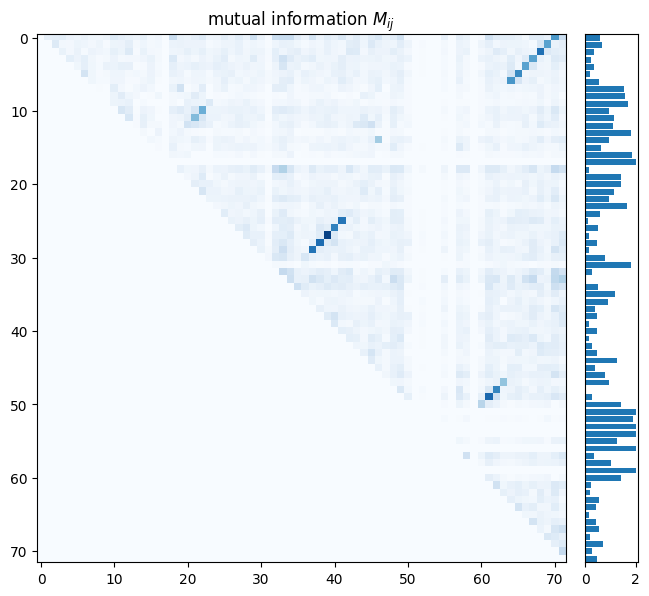

In [9]:
# Make a two-panel figure. ax1 = mutual info  ax2 = primary seq info content
# I fiddle with figsize, width_ratios, and sharey=True to get the two panels aligned the way I want
# I also use vmin=0 vmax=0 on the Mij plot to force the heatmap to use the full range of possible values
#
fig, (ax1, ax2) = plt.subplots( 1,2, figsize=(6.6,6), width_ratios=[1, 0.1], sharey=True, layout='tight')    
ax1.imshow(M, cmap='Blues', vmin=0, vmax=2)
ax2.barh(list(range(L)), info)    # list(range(L)) constructs the x data array corresponding to the info[] y data to plot

ax1.set_title('mutual information $M_{ij}$')
ax2.yaxis.set_visible(False)

## 2. Explain the main features you see in this plot...


We can see four strong diagonals with high mutual information terms. These correspond to the four base-paired stems of the cloverleaf tRNA structure. If I choose a threshold at 0.70 bits by eye, and print out a list of the 18 pairs that satisfy that threshold, I get 7/7 of the pairs in the acceptor stem, 2/4 in the D stem, 5/5 in the anticodon stem, and 3/5 in the TpsiCG stem.

I also get one additional high-mutual-information pair, between 14:46. This turns out to be a 3D _tertiary_ contact in the tRNA, an interaction between the D loop and the TpsiCG loop.

Pairs involving some columns have lower background than others. For example, background is low for positions 51..54. These low-background positions are correlated with the positions that have high primary sequence conservation (the plot on the right). That makes sense: we need sequence variation to be able to measure _co_variation, so positions with higher conservation will tend to have lower $M_{ij}$.

This largely explains why we don't detect a few true base pairs. The D stem (positions 9-12 and 20-23) has some of the highest sequence conservation in the alignment, making it more difficult to detect covariation there.

The code I used to get the list of 18 pairs with $M_{ij} \geq 0.70$:


In [10]:
n = 0
for i in range(L):
    for j in range(i+1, L):
        if M[i][j] >= 0.70:
            print("{:2d} {:2d} {:.2f}".format(i,j,M[i][j]))
            n += 1
print(n)            

 0 70 1.19
 1 69 1.11
 2 68 1.50
 3 67 1.11
 4 66 1.11
 5 65 1.31
 6 64 1.21
10 22 1.00
11 21 0.88
14 46 0.71
25 41 1.46
26 40 1.36
27 39 1.86
28 38 1.53
29 37 1.47
47 63 0.80
48 62 1.34
49 61 1.58
18


## 3. write code to produce negative control alignments...

I can think of two ways to randomize the input MSA in a way that preserves primary sequence composition in each column, therefore preserving both the overall residue composition of the alignment (like, is it high- or low-GC%) as well as the pattern of primary sequence conservation, while destroying any pairwise correlations. I can **shuffle** each column of the MSA independently, or I can make a position-specific probability matrix from the MSA and then **sample** simulated sequences by sampling from that model. 

Because both methods shuffle/sample each column _independently_, there is zero true covariation in the resulting negative control MSA. Any covariation we measure is statistical noise. We will collect the distribution of this noise, and use it to empirically decide how high an $M_{ij}$ value needs to be for this particular alignment, with its particular composition and primary sequence conservation pattern, to believe that the $M_{ij}$ value is "significant": unlikely to just result from statistical noise.

Shuffling vs. sampling give essentially identical results here. Shuffling _exactly_ conserves the composition of each column; sampling _approximately_ conserves it.

In [11]:
def shuffle_msa(rng, msa):
    (nseq, L) = msa.shape
    shuf = msa.copy()          # Make a copy that I can shuffle, without destroying the original MSA, which I still need.

    for i in range(L):
        rng.shuffle(shuf[:,i])   # shuf[:,i] is a "slice" that selects column i. rng.shuffle() then shuffles that column in place.
    return shuf        

In [12]:
def sample_msa(rng, msa):
    (nseq, L) = msa.shape
    pmx = make_probmx(msa)
    samp = np.empty( (nseq, L) ).astype(str)          # I've got to use .astype() to tell numpy this will be an array of chars (strings)
    for i in range(L):
        samp[:,i] = rng.choice(list('ACGT'), nseq, p=pmx[i])
    return samp    

Let's have a look at what an analysis of a shuffled alignment looks like:

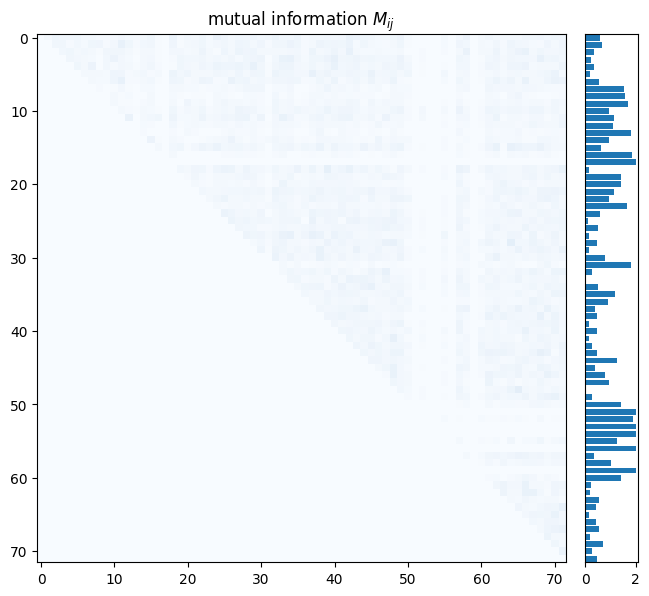

In [13]:
shuf   = shuffle_msa(rng, msa)
M_shuf = mutual_information(shuf)
info   = primary_conservation(shuf)

fig, (ax1, ax2) = plt.subplots( 1,2, figsize=(6.6,6), width_ratios=[1, 0.1], sharey=True, layout='tight')    
ax1.imshow(M_shuf, cmap='Blues', vmin=0, vmax=2)
ax2.barh(list(range(L)), info)    # list(range(L)) constructs the x data array corresponding to the info[] y data to plot

ax1.set_title('mutual information $M_{ij}$')
ax2.yaxis.set_visible(False)

Looks good. We've essentially flatlined the mutual information, while leaving the primary sequence conservation as it was. What's left is the statistical sampling noise that we want to quantitate.

The sequence conservation pattern affects the expected noise. We can see that the highly conserved TpsiCG loop residues have low mutual information terms even in a shuffled alignment.

## 4. Collect and plot the null distribution of Mij values...

Let's collect a bunch of $M_{ij}$ values now from 10 shuffled alignments, to generate an empirical expected null distribution for the $M_{ij}$ statistic.

I'll just collect these in one big list. When I go to plot, I know that the matplotlib `ecdf()` function will handle all the sorting and integrating for me, to collate the complementary cumulative distribution function I want to see.

In [14]:
(nseq, L) = msa.shape
nruns  = 10
D_shuf = []
for r in range(nruns):
    shuf   = shuffle_msa(rng, msa)
    M_shuf = mutual_information(shuf)
    for i in range(L):
        for j in range(i+1, L):
            D_shuf.append(M_shuf[i][j])        

I'll compare that distribution to the distribution from the real alignment.

In [15]:
D = []
for i in range(L):
  for j in range(i+1, L):
    D.append(M[i][j])

Time to plot $P(M_{ij} > t$ for those two distributions, as a function of threshold $t$.

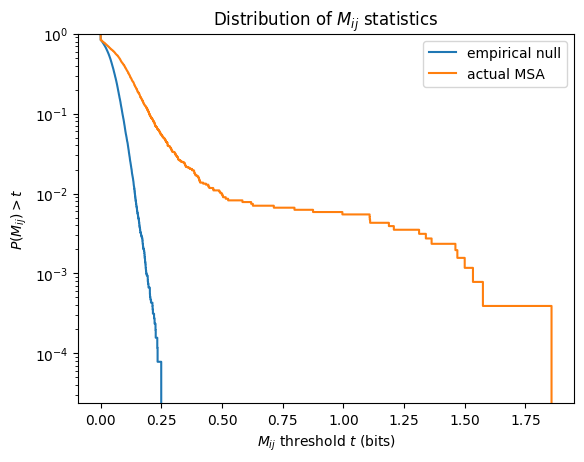

In [16]:
fig, ax = plt.subplots()
ax.ecdf(D_shuf, complementary=True)
ax.ecdf(D,      complementary=True)
ax.set_title('Distribution of $M_{ij}$ statistics')
ax.set_yscale('log')
ax.set_xlabel('$M_{ij}$ threshold $t$ (bits)')
ax.set_ylabel('$P(M_{ij}) > t$')
ax.legend(['empirical null', 'actual MSA'])

Based on this, I get to choose what I'll accept as "statistically significant". 

In 10 simulated alignments, I never saw any $M_{ij}$ > 0.25 or so. That would seem to make 0.25 a safe threshold to choose. 

If I were a classical biostatistician, I might choose a threshold that gives me a $\leq 0.05$ probability of a false positive call. That would be much more aggressive and less safe; that'd be a threshold around 0.10-0.15, looks like. I might remember to correct my P=0.05 false probability _per $M_{ij}$ evaluation_ for _multiple testing_: I did 2556 tests, and I really don't want any false positives in any of them. So I might try to make the probability of _any_ false positive in N tests be smaller than, say, 0.05... I'm reinventing something called a _Bonferroni correction_, which we will see later in the course.

But by looking at the simulated vs. real data, I can observe that there's something much more important going on. Many $ij$ pairs in the real alignment are giving me very significant (>0.25) $M_{ij}$ values: more than I expect from the number of true base pairs. There are 140 $ij$ pairs with $M_{ij} > 0.25$. There can't be more than L/2 disjoint base pairs in an RNA secondary structure. Something else must be generating "significant" pairs?

Turns out that this is the phylogeny (evolutionary tree) of the tRNA sequences. The 100 sequences aren't independent of each other, but the $M_{ij}$ calculation assumes that they are. Imagine a branch of the evolutionary tree where there is a substitution at position $i$ and an unrelated substitution just happens to also happen at position $j$. And now imagine that we have a bunch of descendants from that new sequence. What we'll see then is a bunch of counts of the original ancestral sequence at those positions, and a bunch of counts of the new descendant sequence; it will look like a strong pairwise correlation, basically because the phylogenetic tree is causing us to count what's essentially a single event as multiple events. The sequences in this example are real tRNA sequences, with a phylogeny, so we're getting substantial noise from that source. Classical statistics -- rejecting the null hypothesis -- could have led us astray, if we overlook an important source of false signal.

So for my purposes here: I still like the 0.70 threshold that I dialed in manually, which got me to the high-scoring 18 pairs, 17 of which are consensus tRNA base pairs, and one of which is a "correct" 3D contact. These empirical statistics serve to confirm that my 0.70 choice is not stupid. It's an overwhelmingly "significant" threshold, given the simple shuffling-based null distribution.

## 5. Extract a list of all the putative consensus base pairs...

... and compare to the list of true consensus base pairs.

Well, I already extracted that list above, so I'll repeat that cell now, and edit that code so it saves a list of predicted base pairs as tuples.

In [17]:
bp_pred = []
n = 0
for i in range(L):
    for j in range(i+1, L):
        if M[i][j] >= 0.70:
            bp_pred.append( (i, j) )
            n += 1
print(n)            

18


In [18]:
true_set = set(bp_list)
pred_set = set(bp_pred)

TP = true_set.intersection(pred_set)
FN = true_set.difference(pred_set)
FP = pred_set.difference(true_set)

TPR = len(TP) / len(bp_list)     # "true positive rate":   what fraction of true pairs did we detect
FNR = len(FN) / len(bp_list)     # "false negative rate":  what fraction of true pairs did we fail to detect
FDR = len(FP) / len(bp_pred)     # "false discovery rate": what fraction of our predictions are wrong

print("Detected {} pairs of {} true:  TPR (sensitivity) = {:.0f}%".format(len(TP), len(bp_list), TPR*100))

print("Additionally detected {} more pair(s): {}".format(len(FP), FP))

Detected 17 pairs of 21 true:  TPR (sensitivity) = 81%
Additionally detected 1 more pair(s): {(14, 46)}


As I already said above, that "false" 14:46 pair is an exception proving the rule: it's actually a true interaction in the tRNA structure, but in the 3D structure, not the 2D secondary structure.

## 6. Does this support the idea that Wiggins' sequence is a tRNA?

I'd say yes! The pairwise covariations strongly support the expected tRNA consensus cloverleaf structure.



## _further reading_

The sequences here are real phage tRNA sequences from SEA-PHAGEs. I just carefully selected a set of 100 that have an ungapped sequence alignment, so we didn't have to deal with insertion and deletion.

Mutual information calculations for RNA structure inference were introduced by at least a couple different papers, but perhaps most influentially by [Gutell et al. (1990)](https://doi.org/10.1093/nar/20.21.5785). Check out Figure 2!